In [87]:
import os
import pandas as pd
import numpy as np
from shutil import rmtree, copyfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
from keras import Model
from keras.layers import Input, Bidirectional, GlobalMaxPool1D, Dense, Dropout, LSTM, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, average_precision_score
import seaborn as sb
from tensorflow.keras.utils import to_categorical
from itertools import cycle

# Project variables

In [2]:
m_name = "distilbert_4_classes"
p_dir = os.path.join("../nlp models", m_name)

In [3]:
def create_dir(dir_path: str):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

In [4]:
def clear_dir(dir_path: str):
    for item in os.listdir(dir_path):
        fp = os.path.join(dir_path, item)
        if os.path.isfile(fp):
            os.remove(fp)
        if os.path.isdir(fp):
            rmtree(fp)

In [5]:
create_dir(p_dir)
clear_dir(p_dir)

# Read and transform scraped dataframes

In [6]:
fp = "../scraped data"

channels = pd.read_pickle(os.path.join(fp, "channels.pkl"))
videos = pd.read_pickle(os.path.join(fp, "videos.pkl"))

In [7]:
def transform_channels(df: pd.DataFrame) -> pd.DataFrame:
    # Date string into proper date
    df.published = pd.to_datetime(df.published)
    
    # Convert field type into int64
    fields = ["video_count", "view_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("int64")
    
    # Convert field type into float64
    fields = ["subscriber_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("float64")
    
    # Add of channel in months
    df["age_mth"] = (pd.to_datetime("today", utc=True).year - df.published.dt.year) * 12 \
        + (pd.to_datetime("today", utc=True).month - df.published.dt.month)
        
    # Drop unnecessary fields
    df.drop(columns=["custom_url", "country"] + [c for c in df.columns if c.startswith("thumbnail")], inplace=True)
    
    # Remove channels without subscriber_count
    df = df.loc[df.subscriber_count.notnull(), :]
    
    return df

In [8]:
def transform_videos(df: pd.DataFrame) -> pd.DataFrame:    
    # Date string into proper date
    df.published = pd.to_datetime(df.published)
    
    # Convert field type to bool
    fields = ["broadcast"]
    df.loc[:, fields] = df.loc[:, fields].astype("bool")
    
    # Convert field type into int64
    fields = ["category_id"]
    df.loc[:, fields] = df.loc[:, fields].astype("int64")
    
    # Convert field type into float64
    fields = ["comment_count", "dislike_count", "like_count", "view_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("float64")
    
    df["published_mth"] = (pd.to_datetime("today", utc=True).year - df.published.dt.year) * 12 \
        + (pd.to_datetime("today", utc=True).month - df.published.dt.month)
    df["title_len"] = df.title.str.len()
    
    df.drop(columns=["favorite_count", "broadcast", "audio_language", "comment_count", "category_id"] \
            + [c for c in df.columns if c.startswith("thumbnail")], inplace=True)
    
    df = df.loc[df.like_count.notnull() & df.dislike_count.notnull() & df.view_count.notnull(), :]
    
    return df

In [9]:
channels_trans = transform_channels(channels)
videos_trans = transform_videos(videos)
combo = videos_trans.merge(channels_trans[["id", "view_count","published", "age_mth", "subscriber_count",
                                             "video_count"]], 
                           how="inner", left_on="channel_id", right_on="id", suffixes=["_video", "_channel"])
combo["ln_vc_norm"] = np.log(combo.view_count_video / combo.subscriber_count)

# Define categories

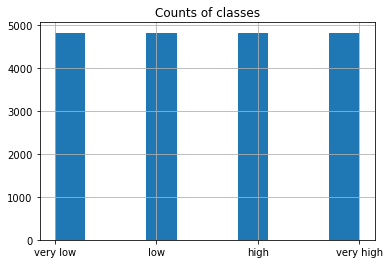

In [10]:
cat_lbl = ["very low", "low", "high", "very high"]
combo.loc[:, "qtl"] = pd.qcut(combo.ln_vc_norm, len(cat_lbl), labels=cat_lbl, precision=6)
combo.sort_values(by=["qtl"]).qtl.hist()
plt.title("Counts of classes")
plt.show()

# Split dataset (use only top and bottom quartile data)

In [11]:
y = combo.qtl
x = combo.loc[:, [c for c in combo.columns if c != "qtl"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=4711)

x_train.to_pickle(os.path.join(p_dir, "x_train.pkl"))
y_train.to_pickle(os.path.join(p_dir, "y_train.pkl"))
x_val.to_pickle(os.path.join(p_dir,"x_val.pkl"))
y_val.to_pickle(os.path.join(p_dir, "y_val.pkl"))
x_test.to_pickle(os.path.join(p_dir,"x_test.pkl"))
y_test.to_pickle(os.path.join(p_dir, "y_test.pkl"))

print(x_train.shape[0], x_val.shape[0], x_test.shape[0])

11586 3862 3863


# Build the model

In [12]:
def preprocessing(df: pd.DataFrame, remove_stopwords: bool=False) -> pd.DataFrame:
    field = "title"
    stw = set(stopwords.words("english"))
    
    def cleanse_row(row, field, stw, stopwords=False):
        # Remove HTML from text
        soup = BeautifulSoup(row[field])
        row[field] = soup.get_text()
        
        # Remove stopwords
        if stopwords:
            row[field] = " ".join([w for w in row[field].split() if w not in stw])
        
        return row
    
    df = df.apply(lambda row: cleanse_row(row, field, stw, remove_stopwords), axis=1)
    return df["title"]

In [13]:
# Download the stopwork corpus
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
remove_stopwords = False

def preprocess_data(x: pd.DataFrame, remove_stopwords: bool=False) -> list():
    x_pp = preprocessing(x, remove_stopwords)
    x_pp = x_pp.tolist()
    return x_pp

In [15]:
x_train_pp = preprocess_data(x_train)
x_val_pp = preprocess_data(x_val)

In [16]:
pt_model = "distilbert-base-uncased"
tok = DistilBertTokenizer.from_pretrained(pt_model, do_lower=True, add_special_tokens=True, max_length=100, pad_to_max_length=True)

In [28]:
def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=100, padding="max_length", return_attention_mask=True, 
                                       return_token_type_ids=True, truncation=True)
        input_ids.append(inputs["input_ids"])
        input_masks.append(inputs["attention_mask"])
        input_segments.append(inputs["token_type_ids"])
        
    return np.asarray(input_ids, dtype="int32"), np.asarray(input_masks, dtype="int32"), np.asarray(input_segments, dtype="int32")

In [40]:
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states=False
transformer_model = TFDistilBertModel.from_pretrained(pt_model, config=config)

in_ids = Input(shape=(100,), name="input_token", dtype="int32")
in_masks = Input(shape=(100,), name="masked_token", dtype="int32")

emb = transformer_model(in_ids, attention_mask=in_masks)[0]
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0))(emb)
x = GlobalMaxPool1D()(x)
x = Flatten()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(4, activation="softmax")(x)
model = Model(inputs=[in_ids, in_masks], outputs=x)

for layer in model.layers[:3]:
    layer.trainable = False

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [41]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_2 (TFDisti TFBaseModelOutput(la 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 100, 100)     327600      tf_distil_bert_model_2[0][0

# Train the model

In [47]:
x_train_tok = tokenize(x_train_pp, tok)
x_val_tok = tokenize(x_val_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)
y_val_b = lb.transform(y_val)

batch_size = 64
n_epochs = 200

model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(learning_rate=0.00005), 
              metrics=["accuracy"])

metric = "val_loss"

es = EarlyStopping(monitor=metric, 
                   mode="min", 
                   patience=5, 
                   restore_best_weights=True)

checkpoint = ModelCheckpoint(os.path.join(p_dir, "{}".format(m_name)), 
                             monitor=metric, 
                             verbose=2, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min')

hist = model.fit(x_train_tok[:2], y_train_b, 
                 validation_data=(x_val_tok[:2], y_val_b), 
                 batch_size=batch_size, 
                 epochs=n_epochs, 
                 callbacks=[checkpoint, es])

Epoch 1/200
182/182 [==============================] - 59s 285ms/step - loss: 1.2873 - accuracy: 0.3790 - val_loss: 1.2072 - val_accuracy: 0.4303

Epoch 00001: val_loss improved from inf to 1.20721, saving model to ../nlp models/distilbert_4_classes/distilbert_4_classes
Epoch 2/200
182/182 [==============================] - 52s 285ms/step - loss: 1.2046 - accuracy: 0.4293 - val_loss: 1.1683 - val_accuracy: 0.4521

Epoch 00002: val_loss improved from 1.20721 to 1.16826, saving model to ../nlp models/distilbert_4_classes/distilbert_4_classes
Epoch 3/200
182/182 [==============================] - 52s 288ms/step - loss: 1.1798 - accuracy: 0.4425 - val_loss: 1.1511 - val_accuracy: 0.4744

Epoch 00003: val_loss improved from 1.16826 to 1.15112, saving model to ../nlp models/distilbert_4_classes/distilbert_4_classes
Epoch 4/200
182/182 [==============================] - 52s 288ms/step - loss: 1.1619 - accuracy: 0.4581 - val_loss: 1.1372 - val_accuracy: 0.4806

Epoch 00004: val_loss improved f

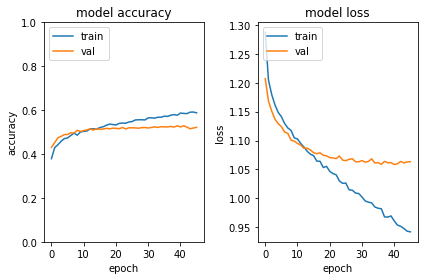

In [49]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(hist.history["accuracy"])
axs[0].plot(hist.history["val_accuracy"])
axs[0].set_title("model accuracy")
axs[0].set_ylabel("accuracy")
axs[0].set_xlabel("epoch")
axs[0].set_ylim(0, 1)
axs[0].legend(["train", "val"], loc="upper left")

axs[1].plot(hist.history["loss"])
axs[1].plot(hist.history["val_loss"])
axs[1].set_title("model loss")
axs[1].set_ylabel("loss")
axs[1].set_xlabel("epoch")
# axs[1].set_ylim(0, 1)
axs[1].legend(["train", "val"], loc="upper left")

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(p_dir, "accuracy_loss.jpg"))

# Confusion matrix

In [50]:
model.load_weights(os.path.join(p_dir, "{}".format(m_name)))

## Validation data (in-sample)

In [124]:
x_val_tok = tokenize(x_val_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)
y_val_b = lb.transform(y_val)

y_val_prob = model.predict(x_val_tok[:2], steps=y_val_b.shape[0])
y_pred = np.argmax(y_val_prob, axis=1)
cls_lbl = {c[0]: c[1] for c in list(zip(lb.classes_, range(4)))}
cls_lbl = dict([(v, k) for k, v in cls_lbl.items()])
y_pred = pd.Series([cls_lbl[i] for i in y_pred]).astype("category").cat.reorder_categories(cat_lbl)

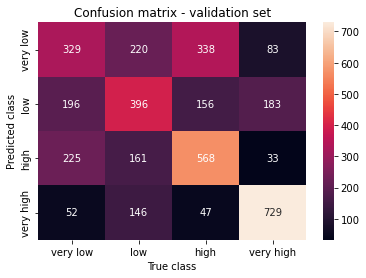

Accuracy: 0.52
Micro precision: 0.52
Micro recall: 0.52
Micro F1-score: 0.52
Macro precision: 0.52
Macro recall: 0.52
Macro F1-score: 0.52
Weighted precision: 0.52
Weighted recall: 0.52
Weighted F1-score: 0.52
              precision    recall  f1-score   support

    very low       0.41      0.34      0.37       970
         low       0.43      0.43      0.43       931
        high       0.51      0.58      0.54       987
   very high       0.71      0.75      0.73       974

    accuracy                           0.52      3862
   macro avg       0.52      0.52      0.52      3862
weighted avg       0.52      0.52      0.52      3862



In [127]:
cmtx = confusion_matrix(y_val, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=cat_lbl, yticklabels=cat_lbl)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - validation set")
plt.savefig(os.path.join(p_dir, "confusion_matrix_val.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_val, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_val, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_val, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_val, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_val, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_val, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_val, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_val, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_val, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_val, y_pred, average="weighted")))

print(classification_report(y_val, y_pred, target_names=cat_lbl))

## Test data (out-of-sample)

In [129]:
x_test_pp = preprocess_data(x_test)
x_test_tok = tokenize(x_test_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)
y_test_b = lb.transform(y_test)

y_test_prob = model.predict(x_test_tok[:2], steps=y_test_b.shape[0])
y_pred = np.argmax(y_test_prob, axis=1)
cls_lbl = {c[0]: c[1] for c in list(zip(lb.classes_, range(4)))}
cls_lbl = dict([(v, k) for k, v in cls_lbl.items()])
y_pred = pd.Series([cls_lbl[i] for i in y_pred]).astype("category").cat.reorder_categories(cat_lbl)

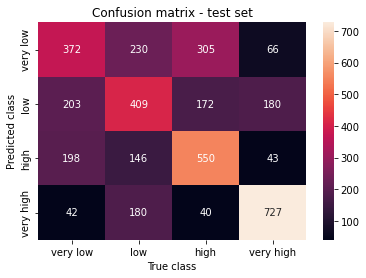

Accuracy: 0.53
Micro precision: 0.53
Micro recall: 0.53
Micro F1-score: 0.53
Macro precision: 0.53
Macro recall: 0.53
Macro F1-score: 0.53
Weighted precision: 0.53
Weighted recall: 0.53
Weighted F1-score: 0.53
              precision    recall  f1-score   support

    very low       0.46      0.38      0.42       973
         low       0.42      0.42      0.42       964
        high       0.52      0.59      0.55       937
   very high       0.72      0.74      0.73       989

    accuracy                           0.53      3863
   macro avg       0.53      0.53      0.53      3863
weighted avg       0.53      0.53      0.53      3863



In [130]:
cmtx = confusion_matrix(y_test, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=cat_lbl, yticklabels=cat_lbl)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - test set")
plt.savefig(os.path.join(p_dir, "confusion_matrix_test.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_test, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_test, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_test, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="weighted")))

print(classification_report(y_test, y_pred, target_names=cat_lbl))

# ROC curve

## Validation data (in-sample)

In [131]:
lb = LabelBinarizer()
y_val_no = lb.fit_transform(y_val)
y_pred_no = y_val_prob

In [132]:
def roc_curve_multiple_classes(y_test, y_pred, labelbinarizer, title, file_path):
    n_classes = len(y_test[0])
    lw = 2
    lbl = lb.classes_
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        
    mean_tpr /= n_classes
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    plt.figure(1)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(["blue", "red", "green", "yellow"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(lbl[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(file_path)
    plt.show()

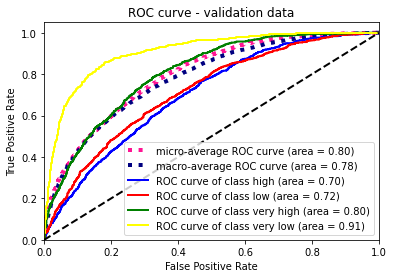

In [133]:
roc_curve_multiple_classes(y_val_no, y_pred_no, lb, "ROC curve - validation data", os.path.join(p_dir, "roc_curve_val.jpg"))

## Test data (out-of-sample)

In [134]:
lb = LabelBinarizer()
y_test_no = lb.fit_transform(y_test)
y_pred_no = y_test_prob

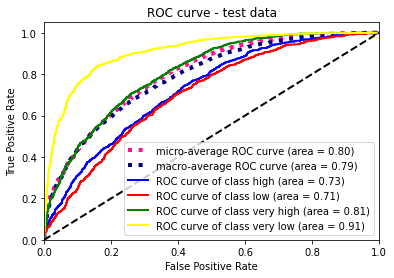

In [135]:
roc_curve_multiple_classes(y_test_no, y_pred_no, lb, "ROC curve - test data", os.path.join(p_dir, "roc_curve.jpg"))

# Class probability histograms

## Without middle classes

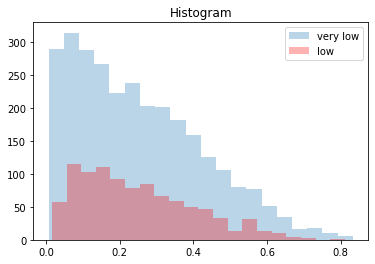

In [93]:
m0 = y_test_no[:, 0] == 0
c0 = y_test_prob[m0, 1]
m1 = y_test_no[:, 0] == 1
c1 = y_test_prob[m1, 1]

plt.hist(c0, alpha=0.3, bins=20)
plt.hist(c1, color="red", alpha=0.3, bins=20)
plt.title("Histogram")
plt.legend(cat_lbl)
plt.savefig(os.path.join(p_dir, "histogram.jpg"))
plt.show()

## Including middle classes

In [33]:
cat_lbl2 = ["very low", "low", "high", "very high"]
combo2 = combo.copy()
combo2.loc[:, "qtl"] = pd.qcut(combo.ln_vc_norm, len(cat_lbl2), labels=cat_lbl2, precision=6)

In [34]:
combo2 = combo2.loc[combo2.qtl.isin(["low", "high"]), :]
combo2.qtl = combo2.qtl.cat.remove_unused_categories()

y2 = combo2.qtl
x2 = combo2.loc[:, [c for c in combo2.columns if c != "qtl"]]

x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, random_state=42)
x_train2, x_val2, y_train2, y_val2 = train_test_split(x_train2, y_train2, test_size=0.25, random_state=4711)

print(x_train2.shape[0], x_val2.shape[0], x_test2.shape[0])

2896 966 966


In [35]:
x_test_pp2 = preprocess_data(x_test2)
x_test_tok2 = tokenize(x_test_pp2, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)
y_test_b2 = lb.transform(y_test2)

y_pred_prob2 = model.predict(x_test_tok2[:2], steps=y_test_b2.shape[0])
y_pred2 = np.argmax(y_pred_prob2, axis=1)
y_pred2 = lb.inverse_transform(y_pred2)

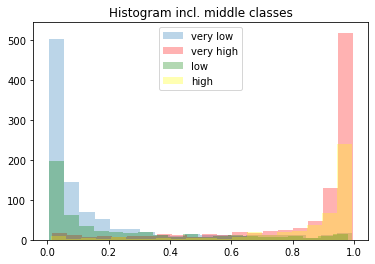

In [36]:
m0 = y_test_no[:, 0] == 0
c0 = y_test_prob[m0, 1]
m1 = y_test_no[:, 0] == 1
c1 = y_test_prob[m1, 1]

m3 = y_test2 == "low"
c2 = y_pred_prob2[m3, 0]

m4 = y_test2 == "high"
c3 = y_pred_prob2[m4, 0]

plt.hist(c0, alpha=0.3, label="", bins=20)
plt.hist(c1, color="red", alpha=0.3, label="", bins=20)
plt.hist(c2, color="green", alpha=0.3, label="", bins=20)
plt.hist(c3, color="yellow", alpha=0.3, label="", bins=20)
plt.title("Histogram incl. middle classes")
plt.legend(cat_lbl + ["low", "high"])
plt.savefig(os.path.join(p_dir, "histogram_w_medium.jpg"))
plt.show()

# Sample titles

## Validation dataset

In [37]:
x1 = x_test2[["title", "channel_name"]]
x2 = y_test2
x3 = pd.Series(y_pred2, name="pred")

x4 = x_test[["title", "channel_name"]]
x5 = y_test
x6 = pd.Series(y_pred, name="pred")

c1 = pd.concat([x1, x2], axis=1).reset_index(drop=True)
c1 = pd.concat([c1, x3], axis=1)

c2 = pd.concat([x4, x5], axis=1).reset_index(drop=True)
c2 = pd.concat([c2, x6], axis=1)

c3 = pd.concat([c1, c2])

print(c3.shape)
c3.head()

(2898, 4)


,title,channel_name,qtl,pred
0,Why Do You Love Your Family?,It's Okay To Be Smart,high,very high
1,Artificial Intelligence Tutorial | Artificial ...,Simplilearn,high,very low
2,The Force - Sixty Symbols,Sixty Symbols,high,very high
3,Bamboo Engineering,Massachusetts Institute of Technology (MIT),high,very low
4,HARP TWINS and more... -- BiDiPi #17,Vsauce2,high,very high


In [38]:
g = c3.loc[c3["qtl"].isin(["very high", "very low"]), :].groupby("pred", as_index=False).apply(lambda x: x.sample(5, random_state=256))
# g = g.loc[g["qtl"].isin(["very low"]), "title"]
g[["title", "pred"]].head(10)

title       pred
0 1782              The Halifax Explosion - Sixty Symbols  very high
  1409                        Is Zero Even? - Numberphile  very high
  1503            History vs. Genghis Khan - Alex Gendler  very high
  1295                          A Game You Can Always Win  very high
  1806  Can you solve the $20 riddle? ft SMBC Comics' ...  very high
1 165           The most significant genius: Emmy Noether   very low
  1476  What is Layer 2 Security? | What is Port Secur...   very low
  980   What Is Audit | CompTIA Cloud+ Training | Simp...   very low
  434   Big Data Use Cases | Big Data in Publishing - ...   very low
  1375  Loops In JavaScript | JavaScript Loops Example...   very low

In [41]:
g.to_csv(os.path.join(p_dir, "titles.csv"), index=False)